In [1]:
import pandas as pd
import numpy as np
import networkx as nx

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

# Load parameters

import sys
from datawand.parametrization import ParamHelper

ph = ParamHelper('..', 'LNGraph', sys.argv)

# Data

In [3]:
snapshots = pd.read_csv("/mnt/idms/fberes/data/bitcoin_ln_research/directed_temporal_edges.csv")

In [4]:
node_meta = pd.read_csv("/mnt/idms/fberes/data/bitcoin_ln_research/node_meta_with_labels.csv")

In [5]:
providers = list(node_meta["pub_key"])
len(providers)

181

In [6]:
snapshots.head()

,src,trg,snapshot_id,num_channels,capacity,fee_base_msat,fee_rate_milli_msat
0,0200072fd301cb4a680f26d87c28b705ccd6a1d5b00f1b...,02004c625d622245606a1ea2c1c69cfb4516b703b47945...,7,1,1000000,1000.0,1.0
1,0200072fd301cb4a680f26d87c28b705ccd6a1d5b00f1b...,0202497639162bf2b608152aa2659c4dbd25bb0d3fbd5c...,4,1,500000,1000.0,1.0
2,0200072fd301cb4a680f26d87c28b705ccd6a1d5b00f1b...,0202497639162bf2b608152aa2659c4dbd25bb0d3fbd5c...,5,1,500000,1000.0,1.0
3,0200072fd301cb4a680f26d87c28b705ccd6a1d5b00f1b...,0202497639162bf2b608152aa2659c4dbd25bb0d3fbd5c...,6,1,500000,1000.0,1.0
4,0200072fd301cb4a680f26d87c28b705ccd6a1d5b00f1b...,0202497639162bf2b608152aa2659c4dbd25bb0d3fbd5c...,7,1,500000,1000.0,1.0


In [7]:
edges = snapshots[snapshots["snapshot_id"]==0]

In [8]:
edges.shape

(41818, 7)

# Graph and paths

In [9]:
G = nx.from_pandas_dataframe(edges, source="src", target="trg", edge_attr=["capacity","fee_base_msat","fee_rate_milli_msat"])

In [10]:
G.number_of_nodes(), G.number_of_edges()

(2844, 20909)

In [11]:
common_providers = list(set(providers).intersection(set(G.nodes())))
len(common_providers)

135

In [12]:
def get_src_proba(df, alpha):
    df["src_proba"] = alpha / (alpha + df["degree"])
    df["src_proba"] = df["src_proba"] / df["src_proba"].sum()
    
def get_trg_proba(df, eps, providers):
    df["trg_proba"] = eps + (1.0 - eps) * df.apply(lambda x: x["degree"] if x["pub_key"] in providers else 0.0, axis=1)
    df["trg_proba"] = df["trg_proba"] / df["trg_proba"].sum()
    
def init_node_params(G, providers, eps, alpha=None):
    node_variables = pd.DataFrame(list(G.degree()), columns=["pub_key","degree"])
    if alpha == None:
        alpha = node_variables["degree"].mean()
    get_src_proba(node_variables, alpha)
    get_trg_proba(node_variables, eps, providers)
    #print((node_variables < 0).value_counts())
    return node_variables

In [13]:
node_variables = init_node_params(G, common_providers, 0.05, 2.0)

In [14]:
node_variables.head()

,pub_key,degree,src_proba,trg_proba
0,037603400ad316f1711a629629bb4528817c325f058497...,3,0.000406,0.000008
1,0319fec13dcb6df5b6a0cee49e85b4f6c48e5387d62d67...,27,0.000070,0.000008
2,039401f72bc0d40efb58b01de15527a2a5ae1943d7c290...,14,0.000127,0.000008
3,0319b565f91688b1efb9f8d43ea2b043ee781292a2737f...,3,0.000406,0.000008
4,035bb2749325deda9b1f6b3b1b6ae6ba1b8b629d3a219d...,2,0.000508,0.000008


## i.) Sample transactions + Cost calculation for shortest paths

In [15]:
def sample_transactions(node_variables, K=1000):
    nodes = list(node_variables["pub_key"])
    src_selected = np.random.choice(nodes, size=K, replace=True, p=list(node_variables["src_proba"]))
    trg_selected = np.random.choice(nodes, size=K, replace=True, p=list(node_variables["trg_proba"]))
    transactions = pd.DataFrame(list(zip(src_selected, trg_selected)), columns=["source","target"])
    transactions["amount"] = 1
    transactions["transaction_id"] = transactions.index
    transactions = transactions[transactions["source"] != transactions["target"]]
    print(K, len(transactions))
    return transactions[["transaction_id","source","target","amount"]]

def get_shortest_paths(G, transactions, edges, hash_transactions=True, cost_prefix="", weight=None):
    keys = list(zip(edges["src"], edges["trg"]))
    vals = list(zip(edges["fee_base_msat"], edges["fee_rate_milli_msat"]))
    cost_dict = dict(zip(keys,vals))
    shortest_paths = []
    hashed_transactions = {}
    for idx, row in transactions.iterrows():
        try:
            p = nx.shortest_path(G, source=row["source"], target=row["target"], weight=weight)
            cost, routers = process_path(p, row["amount"]*10**8, cost_dict)
            if hash_transactions:
                for router in routers:
                    if not router in hashed_transactions:
                        hashed_transactions[router] = []
                    hashed_transactions[router].append(row)
        except:
            p = []
            cost = None
        finally:
            shortest_paths.append((row["transaction_id"], cost, len(p)-1, p))
    if hash_transactions:
        for node in hashed_transactions:
            hashed_transactions[node] = pd.DataFrame(hashed_transactions[node], columns=transactions.columns)
    return pd.DataFrame(shortest_paths, columns=["transaction_id", cost_prefix+"cost", "length", "path"]), hashed_transactions

def process_path(path, amount_in_satoshi, cost_dict):
    base_sum, rate_sum = 0.0, 0.0
    routers = []
    for i in range(len(path)-2):
        n1, n2 = path[i], path[i+1]
        new_base, new_rate = cost_dict[(n1,n2)]
        base_sum += new_base
        rate_sum += new_rate
        routers.append(n2)
    return base_sum + amount_in_satoshi * rate_sum / 10**6, routers

In [16]:
transactions = sample_transactions(node_variables, 100)

100 100


In [17]:
transactions.head()

,transaction_id,source,target,amount
0,0,0366b4925b67feb6993e2cc735e0efb48dfe9a011e94b0...,032cc4541b25e86e39a7d450a979c1a9adbe2878df3a93...,1
1,1,02cc596b75792d51b6b14fa0b3bb78d7b8f0228e7d24c2...,02725e5abcbf5550fc29e6b19706a1377f25d2b1502684...,1
2,2,03f04acfa512501935bfa73694e463b1c60132956aedbc...,02b2012cb48304468627c689917397805b571f4e72d46d...,1
3,3,03d1af91da3c0cad7d3501b2031db9bd80628e9e829f5d...,021607cfce19a4c5e7e6e738663dfafbbbac262e4ff76c...,1
4,4,0276c75a02783c575c3661c9cba6287e7818f5338a5df9...,02e7c42ae2952d7a71398e23535b53ffc60deb269acbc7...,1


transactions["source"].value_counts()[:10]

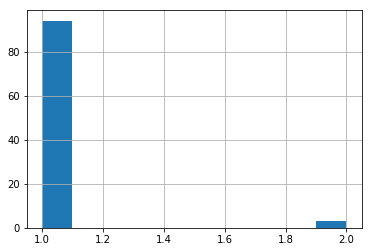

In [18]:
transactions["source"].value_counts().hist()

transactions["target"].value_counts()[:10]

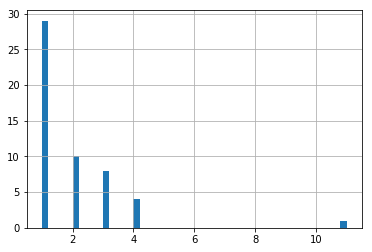

In [19]:
transactions["target"].value_counts().hist(bins=50)

In [20]:
%%time
shortest_paths, hashed_transactions = get_shortest_paths(G, transactions, edges, cost_prefix="original_")

CPU times: user 170 ms, sys: 5 ms, total: 175 ms
Wall time: 173 ms


In [21]:
len(hashed_transactions)

72

In [22]:
shortest_paths.head()

,transaction_id,original_cost,length,path
0,0,11000.0,2,[0366b4925b67feb6993e2cc735e0efb48dfe9a011e94b...
1,1,100000.0,2,[02cc596b75792d51b6b14fa0b3bb78d7b8f0228e7d24c...
2,2,51600.0,3,[03f04acfa512501935bfa73694e463b1c60132956aedb...
3,3,11000.0,2,[03d1af91da3c0cad7d3501b2031db9bd80628e9e829f5...
4,4,1100.0,2,[0276c75a02783c575c3661c9cba6287e7818f5338a5df...


### TODO: PARALLELIZE!!!

In [23]:
def get_shortest_paths_with_node_removals(G, hashed_transactions, edges, cost_prefix="", weight=None):
    bin_sizes = []
    alternative_paths = []
    for node, bucket_transactions in hashed_transactions.items():
        bin_sizes.append(len(bucket_transactions))
        H = G.copy()
        H.remove_node(node)
        new_paths, _ = get_shortest_paths(H, bucket_transactions, edges, hash_transactions=False, cost_prefix=cost_prefix, weight=weight)
        new_paths["removed_node"] = node
        alternative_paths.append(new_paths)
    return pd.concat(alternative_paths), bin_sizes

In [24]:
shortest_paths["length"].value_counts()

2    57
3    41
4     1
1     1
Name: length, dtype: int64

In [25]:
%%time
alternative_paths, bin_sizes = get_shortest_paths_with_node_removals(G, hashed_transactions, edges)

CPU times: user 18.2 s, sys: 91 ms, total: 18.3 s
Wall time: 18.3 s


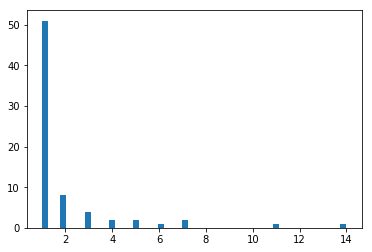

In [26]:
plt.hist(bin_sizes, bins=50)
plt.show()

In [27]:
alternative_paths.head()

,transaction_id,cost,length,path,removed_node
0,60,52500,3,[032c8060fc2b045b1bec6aa7b69b50c62740d5abd974e...,03ebba42db1a05cff6cc69ed28924fe4bf4731995a43fd...
0,19,51600,3,[038a508c73c189c3a06816043f8554cb940832ef160e6...,0230ec892d3951194fa3d3394965277c713b1b6f9fcb2a...
1,88,51600,3,[02e5cad08f3d62a4db973be8603e77826ff97aa10d1f4...,0230ec892d3951194fa3d3394965277c713b1b6f9fcb2a...
0,74,2200,3,[03e26ff2a9df7795cfdd0693a605fe162e93d8f3c9a5d...,03f38829a9b9131e3a0887ca21fd042f2d07bd7f151fff...
0,83,2200,3,[0371298f688c33cecd4ccd3d008a32ec750124088945c...,03321fab5e3db6c378e23e9cceb522325dc4f6b0c68819...


In [28]:
alternative_paths["length"].value_counts()

 3    70
-1    41
 2    23
 4     8
Name: length, dtype: int64

In [29]:
alternative_paths["length"].max()

4

In [30]:
shortest_paths["length"].max()

4

In [31]:
def calculate_node_influence(shortest_paths, alternative_paths, disruption_cost=None):
    s_paths = shortest_paths.copy().drop("path", axis=1)
    a_paths = alternative_paths.copy().drop("path", axis=1)
    if disruption_cost != None:
        a_paths["cost"] = a_paths["cost"].fillna(disruption_cost)
        a_paths["length"] = a_paths["length"].fillna(a_paths["length"].max())
    valid_routing = a_paths[~a_paths["cost"].isnull()]
    routing_diff = valid_routing.merge(s_paths, on="transaction_id", how="left", suffixes=("","_original"))
    routing_diff["cost_diff"] = routing_diff["cost"] - routing_diff["original_cost"]
    routing_diff["length_diff"] = routing_diff["length"] - routing_diff["length_original"]
    grouped = routing_diff.groupby(by="removed_node")
    node_sum_influence = grouped.aggregate({"cost_diff":"sum","length_diff":"sum"}).reset_index()
    node_mean_influence = grouped.aggregate({"cost_diff":"mean","length_diff":"mean"}).reset_index()
    return node_sum_influence.merge(node_mean_influence, on="removed_node", suffixes=("_sum","_mean")), routing_diff

In [32]:
node_influence, routing_differences = calculate_node_influence(shortest_paths, alternative_paths, disruption_cost=10**8)

In [33]:
node_influence.head()

,removed_node,cost_diff_sum,length_diff_sum,cost_diff_mean,length_diff_mean
0,020327bbd6b7ebf577a041e24cbdc0b3ddb6ec4a2ec89e...,49300.0,0,49300.0,0.0
1,0205823109f3d6e1ac5f3e5ab41ab88bf463ffa7b59a81...,99948400.0,-4,99948400.0,-4.0
2,020d41c5a32f06d7addc7378f2d4a6596358d8716a3eb5...,53598.0,2,26799.0,1.0
3,021607cfce19a4c5e7e6e738663dfafbbbac262e4ff76c...,8011.0,0,8011.0,0.0
4,0217890e3aad8d35bc054f43acc00084b25229ecff0ab6...,100051600.0,0,25012900.0,0.0


In [34]:
routing_differences.head()

,transaction_id,cost,length,removed_node,original_cost,length_original,cost_diff,length_diff
0,60,52500.0,3,03ebba42db1a05cff6cc69ed28924fe4bf4731995a43fd...,52500.0,3,0.0,0
1,19,51600.0,3,0230ec892d3951194fa3d3394965277c713b1b6f9fcb2a...,2200.0,3,49400.0,0
2,88,51600.0,3,0230ec892d3951194fa3d3394965277c713b1b6f9fcb2a...,2200.0,3,49400.0,0
3,74,2200.0,3,03f38829a9b9131e3a0887ca21fd042f2d07bd7f151fff...,111000.0,3,-108800.0,0
4,83,2200.0,3,03321fab5e3db6c378e23e9cceb522325dc4f6b0c68819...,2200.0,3,0.0,0


In [35]:
node_influence["cost_diff_mean"].mean(), node_influence["length_diff_mean"].mean()

(30981519.700589225, -1.0812800625300625)

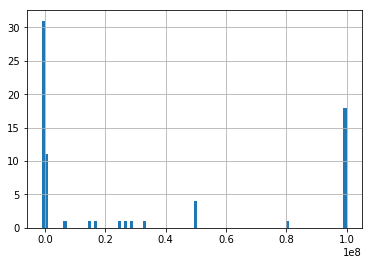

In [36]:
node_influence["cost_diff_mean"].hist(bins=100)

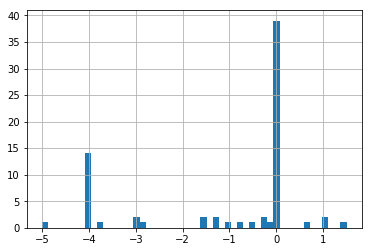

In [37]:
node_influence["length_diff_mean"].hist(bins=50)

In [38]:
influential_nodes = node_influence[np.absolute(node_influence["cost_diff_mean"])>10**6].sort_values("cost_diff_mean")

In [39]:
influential_nodes.shape

(30, 5)

## Only one simulation results

### Worst 3:

- '0232e20e7b68b9b673fb25f48322b151a93186bffe4550045040673797ceca43cf', -8918091.0 : 'Exchange' label
- '03ba4e2c8b5ae8455d4e28646b74db5792611af8ae032290c1960ee65b46b059d3', -3773473.0
- '03ba4e2c8b5ae8455d4e28646b74db5792611af8ae032290c1960ee65b46b059d3', -2998000.0

### Best 3:

- '0217890e3aad8d35bc054f43acc00084b25229ecff0ab68debd82883ad65ee8266', 5595172.0 : 1ML.com
- '02ad6fb8d693dc1e4569bcedefadf5f72a931ae027dc0f0c544b34c1c6f3b9a02b', 3427899.0
- '0331f80652fb840239df8dc99205792bba2e559a05469915804c08420230e23c7c', 3102341.0

In [40]:
list(zip(influential_nodes["removed_node"],influential_nodes["cost_diff_mean"]))

[('0279c22ed7a068d10dc1a38ae66d2d6461e269226c60258c021b1ddcdfe4b00bc4',
  7055559.142857143),
 ('03d37fca0656558de4fd86bbe490a38d84a46228e7ec1361801f54f9437a18d618',
  14252656.857142856),
 ('03864ef025fde8fb587d989186ce6a4a186895ee44a926bfc370e2c366597a3f8f',
  16675083.333333334),
 ('0217890e3aad8d35bc054f43acc00084b25229ecff0ab68debd82883ad65ee8266',
  25012900.0),
 ('02ad6fb8d693dc1e4569bcedefadf5f72a931ae027dc0f0c544b34c1c6f3b9a02b',
  27279081.90909091),
 ('0327049d8d63f0c40193cdf3afc61817c8647808a4e482de0716fcef74e6d92ebf',
  28572843.0),
 ('0391489a933ab83094d1af43b3df3e8c8d467474649361912f05211d0e68a28fc9',
  33284403.0),
 ('028dcc199be86786818c8c32bffe9db8855c5fca98951eec99d1fa335d841605c2',
  49989800.0),
 ('030c3f19d742ca294a55c00376b3b355c3c90d61c6b6b39554dbc7ac19b141c14f',
  50000000.0),
 ('030995c0c0217d763c2274aa6ed69a0bb85fa2f7d118f93631550f3b6219a577f5',
  50000145.0),
 ('03bb88ccc444534da7b5b64b4f7b15e1eccb18e102db0e400d4b9cfe93763aa26d',
  50050650.0),
 ('032b2b3f4a